## Assignment 2: Implementing a Linear Classifier from Scratch

### Prepare the data

In [1]:
data_url = """http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"""
fn = data_url.split("/")[-1]

import urllib.request
urllib.request.urlretrieve(data_url, fn)
!tar zxf review_polarity.tar.gz
!ls

Assignment_2.ipynb     poldata.README.2.0     txt_sentoken
ML_lab_2_v2.ipynb      review_polarity.tar.gz


In [2]:
import os
filenames = list()
for root, dirs, files in os.walk("./txt_sentoken"):
   for name in files:
      filenames.append(os.path.join(root, name))
print("Found %i files" % len(filenames))

Found 2000 files


In [3]:
import numpy as np

X_txt = list()
y = list()
import random
random.shuffle(filenames)
for i, fn in enumerate(filenames):
  if fn.find("/pos/") > 0:
    msg = "positive"
    y.append(1)
  else:
    msg = "negative"
    y.append(0)
  with open(fn) as f:
    X_txt.append(f.read())
  if i < 10:
    print(fn, msg, "example")

y = np.asarray(y)
assert len(X_txt) == y.shape[0]

./txt_sentoken/neg/cv794_17353.txt negative example
./txt_sentoken/neg/cv860_15520.txt negative example
./txt_sentoken/neg/cv105_19135.txt negative example
./txt_sentoken/neg/cv773_20264.txt negative example
./txt_sentoken/pos/cv586_7543.txt positive example
./txt_sentoken/pos/cv786_22497.txt positive example
./txt_sentoken/pos/cv278_13041.txt positive example
./txt_sentoken/neg/cv366_10709.txt negative example
./txt_sentoken/neg/cv496_11185.txt negative example
./txt_sentoken/pos/cv800_12368.txt positive example


### Feature extraction

#### Frist, a token dictionary should be achieved from the documents. <br>Then, vectorized of the token occurance for each document should be achieved in order to get the feature representation.

In [4]:
import string
from string import digits
import re
unique_token_list = set()
for doc in X_txt:
    s = re.sub('['+string.punctuation+']', '', doc).split()
    for token in s:
        unique_token_list.add(token)
s = sorted(unique_token_list)
words = list(s)
len(words)

47568

In [5]:
import numpy as np

feature_dimension = len(words)
matrix_dimension = (2000, len(words))
X = np.zeros(matrix_dimension)
X.shape

(2000, 47568)

In [6]:
lut = dict()
for i, word in enumerate(words):
  lut[word] = i

for word in ['dolphin', 'the', 'coffee']:
  print("'%s' is represented as feature dimension %i" %(word, lut[word]))

'dolphin' is represented as feature dimension 12134
'the' is represented as feature dimension 42254
'coffee' is represented as feature dimension 8076


#### The process of feature extraction is to check the occurance of the tokens for each doc in the token dictionary, if the token occurs, the realtive element in the vector is set to 1, else, set to zero. 

In [7]:
for i in range(2000):
    for w in words:
        if w in X_txt[i]:
            X[i, lut[w]] = 1
print("collomn", i, "processed, feature extraction job Done")

collomn 1999 processed, feature extraction job Done


In [8]:
print(words[2000:2010])
print(X[:10, 2000:2010])
for w in ['dolphin', 'the', 'coffee']:
  print("'%s' in words: %s" %(w, w in words))

['amy', 'amyl', 'amyls', 'amys', 'an', 'ana', 'anabasis', 'anabella', 'anabelle', 'anachronisms']
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]
'dolphin' in words: True
'the' in words: True
'coffee' in words: True


#### The implement of sigmoid, test of sigmoid added also

In [9]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

#### Initialized parameter w and b with specific dimention, w will be set initially with all zero, b is also initially set with zero. 

In [11]:
def initial_parameter(shape):
    w = np.zeros(shape=(shape, 1))
    b = 0
    return w, b

In [150]:
shape = 47568
w, b = initial_parameter(shape)

In [151]:
print("shape of w:", w.shape, "b value", b)

shape of w: (47568, 1) b value 0


In [152]:
y_label = y.reshape(1, 2000)
X_feature = X.reshape(X.shape[0], -1).T 
print("shape of input X", X_feature.shape,",","shape of label", y_label.shape)

shape of input X (47568, 2000) , shape of label (1, 2000)


#### Implement of logistic regression predictor

In [15]:
def lr_predictor(w, X, b):
    Y_hat = sigmoid(np.dot(w.T, X) + b)
    return Y_hat

#### Implement of cost function without regularization

In [172]:
def get_cost(X, Y, Y_hat, Loss = "log"):
    size = X.shape[1]
    if Loss == "log":
        cost = (-1 / size) * np.sum(Y * np.log(Y_hat) + (1-Y) * (np.log(1 - Y_hat)))
    if Loss == "hinge":
        scores = Y_hat
        yi_scores = scores[np.arange(scores.shape[0]),Y]
        margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)
        margins[np.arange(size),Y] = 0
        cost = np.mean(np.sum(margins, axis=1)) *(1/size)
        #shift_scores=scores-np.max(scores,axis=1).reshape(-1,1)
        #softmax_output = np.exp(shift_scores)/np.sum(np.exp(shift_scores), axis = 1).reshape(-1,1)
        #cost=np.sum(-np.log(softmax_output[range(size),Y])) / size
        
    return cost

#### Print out the input parameters' demensions for the model

In [159]:
print("shape of w:", w.shape, ", b value", b)
print("shape of input X", X_feature.shape,",shape of label Y", y_label.shape)

shape of w: (47568, 1) , b value 0
shape of input X (47568, 2000) ,shape of label Y (1, 2000)


#### Next, the regularization should be included. The regularization will help us to avoid overfitting, it will change the cost function and of course, it will change the gradient. 

In [163]:
def get_cost_with_regularization(X, Y, Y_hat, w, beta, L=None, Loss="log"):
    size = X.shape[1]
    cost_1 = get_cost(X, Y, Y_hat, Loss)
    
    if L == None:
        cost_regularization = 0
    elif L == 1:
        cost_regularization = beta*(np.sum(np.abs(w))) / (2* size)
    elif L == 2:
        cost_regularization = beta*(np.sum(np.square(w))) / (2 * size)
    cost = cost_1 + cost_regularization
    
    return cost

In [19]:
def d_abs(x):
    if x > 0:
        return 1
    if x ==0:
        return 0
    if x < 0:
        return -1


np_abs = lambda x: d_abs(x)
vfunc = np.vectorize(np_abs)


In [176]:
def gradient_with_regularization(X, Y, Y_hat, w, beta, L=None, Loss = "log"):
    size = X.shape[1]
    if Loss == "log":
        if L == None:
            dw = (1 / size) * np.dot(X, (Y_hat -Y).T)
        elif L==1:
            dw = (1 / size) * np.dot(X, (Y_hat -Y).T) + (beta* vfunc(w)) /(2*size)
        elif L ==2:
            dw = (1 / size) * np.dot(X, (Y_hat -Y).T) + (beta * w)/size
        db = (1 / size) * np.sum(Y_hat - Y)
    if Loss == "hinge":
        scores = Y_hat
        yi_scores = scores[np.arange(scores.shape[0]),Y]
        margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)
        margins[np.arange(size),Y] = 0
        binary = margins
        binary[margins > 0] = 1
        row_sum = np.sum(binary, axis=1)
        binary[np.arange(size), Y] = -row_sum.T
        #shift_scores=scores-np.max(scores,axis=1).reshape(-1,1)
        #softmax_output = np.exp(shift_scores)/np.sum(np.exp(shift_scores), axis = 1).reshape(-1,1)
        #dw=softmax_output.copy()
        #dw[range(size),Y]-=1
        dw=np.dot(X,binary) / size
        if L == None:
            dw = (1 / size) * dw
        elif L==1:
            dw = (1 / size) * dw + (beta* vfunc(w)) /(2*size)
        elif L ==2:
            dw = (1 / size) * dw + (beta * w)/size
        db = (1 / size) * np.sum(Y_hat - Y)
    
    
    grads = {"dw": dw, "db":db}
    return grads

In [72]:
def propagate_with_regularization(w, b, X, Y, beta, L=None, Loss = "log"):
    Y_hat = lr_predictor(w, X, b)
    grads = gradient_with_regularization(X, Y, Y_hat, w, beta, L, Loss)
    cost = get_cost_with_regularization(X, Y, Y_hat, w, beta, L, Loss)
    return grads, cost

In [174]:
def optimize_with_regularization(w, b, X, Y, num_iterations, learning_rate, beta, L=None, Loss="log", print_result=False):
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate_with_regularization(w, b, X, Y, beta, L, Loss)
        dw = grads["dw"]
        db = grads["db"]
    
        w = w - learning_rate *dw
        b = b - learning_rate *db
        
        if i % 5 == 0:
            costs.append(cost)
            if print_result:
                print("-- Epoch %i" % i)
                print("cost after Epoch %i: %f" % (i, cost))
                print("Bias value is %f" % b)
    
    params = {"w":w, "b":b}
    return params, costs

#### Interpretation of the weights. 
The wight of each token deside how much weigh this token impact the model. For example, token "fail", "stupid", "poor" has high weight, in case these tokens occur in a text, the sentiment is likely a negtive one. A token like "perfect", "great" is likely making a text to be a positive one. 

## Exploring hyperparameters

In [86]:
def predict(w, b, X):
    Y_hat = lr_predictor(w, X, b)
    size = X.shape[1]
    Y_prediction = np.zeros((1, size))
    for i in range(0, size):
        Y_prediction[0, i] = 1 if Y_hat[0, i] > 0.5 else 0
        
    return Y_prediction
    
    

#### Establish the model

In [186]:
def txt_classifier(X_train, Y_train, X_test, Y_test, num_interations, learning_rate, beta, L, Loss, print_result):
    
    shape = X_train.shape[0]
    size = X_train.shape[1]
    w, b = initial_parameter(shape)
    params, costs = optimize_with_regularization(w, b, X_train, Y_train, num_interations, learning_rate, beta, L, Loss, print_result)
    
    w = params["w"]
    b = params["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    train_accuracy = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_accuracy = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    
    validation_accuracy = {"train_accuracy": train_accuracy, "test_accuracy":test_accuracy}
    
    return validation_accuracy
    

In [218]:
## from sklearn.model_selection import KFold, train_test_split, ParameterSampler

# Define the parameters
parameter_distribution = {'Loss': ["log"],
                          'learning_rate': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                          'beta': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                          'L': [1, 2]}
# Placeholder to make fututre comparissons easier
best_hyperparameters = None
for hyperparameters in ParameterSampler(parameter_distribution, n_iter=4):
    print(hyperparameters)
    reguliser_dampening = hyperparameters['beta']
    learning_rate = hyperparameters['learning_rate']
    regulariser = hyperparameters['L']
    loss_function = hyperparameters['Loss']
    
    validation_accuracy = 0
    validation_accuracy_test = 0 
    for train, test in KFold(n_splits=10, shuffle=True).split(X):
        X_train = X[train]
        X_train_re = X_train.reshape(X_train.shape[0], -1).T 
        X_test = X[test]
        X_test_re = X_test.reshape(X_test.shape[0], -1).T 
        y_train = y[train]
        y_train_re = y_train.reshape(y_train.shape[0], -1).T 
        y_test = y[test]
        y_test_re = y_test.reshape(y_test.shape[0], -1).T
        print("K-Fold Validation in process for one set of parameter")
        result = txt_classifier(X_train_re, y_train_re, X_test_re, y_test_re, num_interations=100, learning_rate=learning_rate, beta=reguliser_dampening, L=regulariser, Loss=loss_function, print_result=False)
        validation_accuracy = validation_accuracy + result["train_accuracy"]
        validation_accuracy_test = validation_accuracy_test + result["test_accuracy"]
    everage_accuracy = validation_accuracy / 10
    everage_accuracy_test = validation_accuracy_test / 10
    print("Everage accuracy: {} %".format(everage_accuracy))
    if best_hyperparameters is None or best_hyperparameters[1] < everage_accuracy:
        best_hyperparameters = (hyperparameters, everage_accuracy, everage_accuracy_test)
    print("K-Fold Validation done for one set of parameter")
    
print("----------------------------result------------------------------")    
print("The best hyperparameter", best_hyperparameters[0])
print("With the best hyperparameter, the everage accuracy is: ", best_hyperparameters[1])
print("With the best hyperparameter, the everage accuracy is: ", best_hyperparameters[2])
    



{'learning_rate': 0.0009883615331157487, 'beta': 0.0009883615331157487, 'Loss': 'log', 'L': 2}
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
Everage accuracy: 80.67777777777778 %
K-Fold Validation done for one set of parameter
{'learning_rate': 0.030710690833316446, 'beta': 0.09654893846056296, 'Loss': 'log', 'L': 2}
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in process for one set of parameter
K-Fold Validation in proc

#### From the result we can see that , for the best hyperparameter, the everage accuracy of trainning in KFold cross validation is 86.3% and it everage test accuracy is 78%. It is a OK result. And because the training accuracy is bigger than the test accuracy, thus, there is a little bit of overfitting. 


#### From a qulaitative annalysis, we should refer to the weight and plot. 

In [219]:
params_re, costs_re = optimize_with_regularization(w, b, X_feature, y_label, num_iterations= 100, learning_rate = 0.030710690833316446, beta=0.09654893846056296, L=2, Loss = "log", print_result=False)


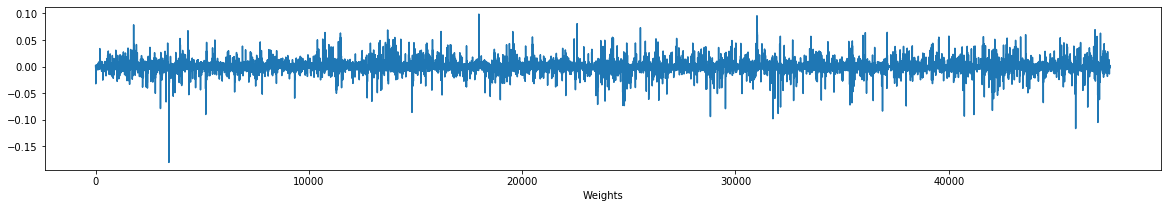

In [220]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(params_re.get('w'))
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

In [221]:
# Pick out the weight vector
w = params_re.get('w')
w_result = w.reshape(47568, )
idx = np.argsort(np.abs(w_result))

print("                Word   Weight  Occurences")
for i in idx[-20:]:
  print("%20s   %.3f\t%i " % (words[i], w[i], np.sum([words[i] in d for d in X_txt])))

                Word   Weight  Occurences
                also   0.079	1071 
             attempt   -0.079	445 
                only   -0.079	1311 
                 joy   0.081	543 
               tempt   -0.082	498 
              script   -0.084	632 
                fail   -0.086	333 
            supposed   -0.087	321 
                poor   -0.088	251 
              boring   -0.090	229 
             suppose   -0.090	386 
              stupid   -0.093	227 
             nothing   -0.094	594 
              nothin   -0.094	595 
             perfect   0.096	403 
                plot   -0.098	1002 
               great   0.099	805 
               worst   -0.105	238 
               waste   -0.117	246 
                 bad   -0.180	825 


#### We can see from the word and weigh plot, some word like "fail, poor, boring, perfect, stupid, great, worst, waste, bad" have high weight impact on the model. It makes sense from human being's knowledge point of view. So, it is a good result. 

### Comments regarding the assignment

I think it is very good assignment, very good for understanding the concept in detail for linear classifier.  <br> I took a lot time trying to understand the matrix with numpy, it is quite tricky and important to make the right shape of the numpy arrays for parameters and input and output.  <br>I spend a lot time in gradient part, trying to translate mathematic formular to numpy array programming.  <br>I also spend a bit time in dealing with the gradient for L1 regularization, because some zero issues has to be dealed with. 